# What this code does
details

## Import ....

In [1]:
import math
from typing import Any

import torch
from torch import Tensor
from torch.nn import init
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F

from torch.nn import Module


In [2]:
class Linear(Module):
    r"""Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

    This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

    On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to ``False``, the layer will not learn an additive bias.
            Default: ``True``

    Shape:
        - Input: :math:`(*, H_{in})` where :math:`*` means any number of
          dimensions including none and :math:`H_{in} = \text{in\_features}`.
        - Output: :math:`(*, H_{out})` where all but the last dimension
          are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

    Attributes:
        weight: the learnable weights of the module of shape
            :math:`(\text{out\_features}, \text{in\_features})`. The values are
            initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`, where
            :math:`k = \frac{1}{\text{in\_features}}`
        bias:   the learnable bias of the module of shape :math:`(\text{out\_features})`.
                If :attr:`bias` is ``True``, the values are initialized from
                :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})` where
                :math:`k = \frac{1}{\text{in\_features}}`

    Examples::

        >>> m = nn.Linear(20, 30)
        >>> input = torch.randn(128, 20)
        >>> output = m(input)
        >>> print(output.size())
        torch.Size([128, 30])
    """
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [3]:
import torch
import torchvision
#torch.cuda.is_available()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
#from torch.autograd.functional import jacobian
#import torch.autograd.functional
import time
import copy
import matplotlib.pyplot as plt
import pandas as pd
torch.set_default_dtype(torch.float64)
batch_size=100
input_size=784
output_size=784
hidden_state_size=10
no_of_layer=2
font = {
        'size'   : 30}
plt.rc('font', **font)

class AE(nn.Module):
    def __init__(self, input_shape,hidden_layer_shape,encoder_output_shape,n,xinit=torch.eye(batch_size,input_size),xfinal=torch.eye(batch_size,input_size),hidden=torch.eye(10,input_size)):
        super().__init__()
        self.encoder_input_layer = Linear(
            in_features=input_shape, out_features=hidden_layer_shape
        )
        self.hidden_layer=Linear(
            in_features=hidden_layer_shape, out_features=hidden_layer_shape
        )
        self.encoder_output_layer = Linear(
            in_features=hidden_layer_shape, out_features=encoder_output_shape
        )
        self.decoder_input_layer = Linear(
            in_features=encoder_output_shape, out_features=hidden_layer_shape
        )
        self.decoder_output_layer =Linear(
            in_features=hidden_layer_shape, out_features=input_shape
        )
        self.number_of_layers=n
        self.xinit=xinit
        self.xfinal=xfinal
        self.hidden=hidden

    def forward(self, features):
        reconstructed=self.internals(features)
        return reconstructed
    
    def internals(self,features):
        code=self.encoder(features)
        self.hidden=code
        #print("hidden state:"+str(code))
        reconstructed=self.decoder(code)
        return reconstructed
    
    def encoder(self,features):
        activation = self.encoder_input_layer(features)
        x = torch.relu(activation)
        self.xinit=x
        for i in range(self.number_of_layers):
            x=torch.relu(self.hidden_layer(x))
        code = self.encoder_output_layer(x)
        result = torch.relu(code)
        return result
    
    def decoder(self,code):
        activation = self.decoder_input_layer(code)
        x = torch.relu(activation)
        for i in range(self.number_of_layers):
             x=torch.relu(self.hidden_layer(x))
        self.xfinal=x
        activation = self.decoder_output_layer(x)
        reconstructed = torch.relu(activation)
        return reconstructed
    
    def xfinals(self):
        return self.xfinal
    
    def xinits(self):
        return self.xinit
    
    def hiddens(self):
        return self.hidden

In [4]:

#transform=
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([
    transforms.ToTensor()
]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([
    transforms.ToTensor()
]))  
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=batch_size,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=batch_size,shuffle=False)

In [5]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_size,output_size,hidden_state_size,no_of_layer).to(device)
# create an optimizer object
# Adam optimizer with learning rate 1e-3

optimizer =torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

cpu


In [6]:
import matplotlib.pyplot as plt 
epochs=10000
asymptotic_repetition=200


#projected_jacobian=[]
ave_len=5


no_of_images,no_of_repetition=100,100
colour=np.arange(1,no_of_repetition+1)
perturbation_strength=10**(-6)
noise_strength=10**(-3)
interval=50

In [7]:
def add_noise(inputs,strength):
    
    noise = torch.randn_like(inputs)*strength
    return inputs + noise
def validation(test_loader):
    
    with torch.no_grad():

     #valid_loss = criterion(outputs, batch_features.view(batch_size,-1).to(device))
        loss=0
        for batch_features, _ in test_loader:
            #input=add_noise(batch_features,).view(100, -1).to(device)
            input_image=add_noise(batch_features,noise_strength).view(batch_size, -1).to(device)
            batch_feature = batch_features.view(batch_size, -1).to(device)
            outputs = model(input_image)
            valid_loss = criterion(outputs, input_image) 
            #accuracy+=kl_div(outputs,batch_features)/batch_size
            loss += valid_loss.item()
    return loss/len(test_loader)
            
def kl_div(output_image,input_image):
    accuracy=0
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    for i in range(len(input_image)):
        input_spectrum=torch.histogram(input_image[i].cpu(), bins=256, density=True)
        output_spectrum=torch.histogram(output_image[i].cpu(), bins=256, density=True)
        accuracy+=kl_loss(input_spectrum[i],output_spectrum[i])
    return accuracy/len(input_image)/256

def iteration(model,initial_inputs,no_of_repetition,epoch):
    y_pred=initial_inputs.to(device)
    for i in range(no_of_repetition):
        x_train=y_pred
        #if i==0:
           # name="progress asymptotic iteration:"+str(i)+" "
           # visualisation(x_train[0].cpu().detach(),epoch,name,False)
        #if i%5==1:
            #name="progress asymptotic iteration:"+str(i)+" "
            #visualisation(x_train[0].cpu().detach(),epoch,name,False)
        y_pred=model.internals(x_train)
    return x_train,y_pred,model 

def asymptotic_jacobian(model,initial_input,no_of_images,no_of_repetition):
    ave_jac=0
    for j in range(no_of_repetition):
        #print("here")
        x_train=initial_input.to(device)
        y_pred=x_train
        mean_jacobian=0
        for i in range(no_of_images):
            x=x_train[i]
            res=torch.autograd.functional.jacobian(model.internals,x)
            norm=torch.norm(res).cpu()
            mean_jacobian+=1/np.sqrt(output_size)*norm
        mean_jacobian=mean_jacobian/no_of_images
        ave_jac+=mean_jacobian
    average_jacobian=ave_jac/no_of_repetition
    return average_jacobian

def spectral_radius(model,initial_input,no_of_repetition,no_of_images):
    result=[]
   
    output=initial_input.to(device)
    product=torch.eye(n=input_size,m=output_size).to(device)
    
    spectral=0

    for i in range(no_of_repetition):
        
        res=torch.autograd.functional.jacobian(model.internals,initial_input)
        product=torch.matmul(product,res)
        output=model(initial_input)
        initial_input=output
    
    s,v=torch.linalg.eig(product)
    #print(s)
    abs=torch.abs(s)
    spectral=np.pow(torch.max(abs).item(),1/no_of_repetition)
    return spectral

def poincare_plot(model,initial_input,dimension_vector,no_of_repetition,colour,epoch):
    xt=[]
    xtminus=[]
    
    output=initial_input
    
    for i in range(no_of_repetition):
        
        initial_input=output
        output=model(initial_input)
        
        xt.append(1/output_size*torch.dot(output,dimension_vector).item())
        xtminus.append(1/output_size*torch.dot(initial_input,dimension_vector).item())
    
    return xt,xtminus
  
    


def asymptotic_distance(xinfinity_unperturbed,xinfinity_perturbed,perturbation):
    result=[]
    for i in range(len(xinfinity_unperturbed)):
    
        sum=0
        
        for j in range(len(xinfinity_unperturbed[i])):
            
            temp=np.linalg.norm(xinfinity_unperturbed[i][j]-xinfinity_perturbed[i][j])
            sum+=temp
        
        result.append(1/output_size*1/len(xinfinity_unperturbed[i])*sum) 
    
    return result


def calculation(model,no_of_images,no_of_repetition,ave_jacobian,spectral_radiuses,image,epoch):
    spectral=0
    
    model_clone=AE(input_size,input_size,hidden_state_size,no_of_layer).to(device)
    model_clone.load_state_dict(copy.deepcopy(model.state_dict()))

    x_train,y_pred,model_clone=iteration(model_clone,image,asymptotic_repetition,epoch)   
    ave_jac,distibution= asymptotic_jacobian(model_clone,x_train,100,no_of_repetition)
   
    average_jacobian.append(ave_jac)
    
    x = [ele.real for ele in s]
    # extract imaginary part
    y = [ele.imag for ele in s]
    #for i in range(no_of_images):
    
        #spectral+=spectral_radius(model_clone,x_train[i],no_of_repetition,no_of_images)
    
   # spectral_radiuses.append(spectral/no_of_images)
    return x_train,y_pred,average_jacobian,spectral_radiuses,model_clone


def asymptotic_iteration(model,initial_inputs,perturbed_inputs,no_of_repetition,no_of_image,cutoff):
    
    y_pred_unperturbed=initial_inputs.to(device)
    y_pred_perturbed=perturbed_inputs.to(device)
    
    distance=[]
    hidden_layer=[]
    hiddens=[]
    chaos=0
    lowest=10**10
    dist=[]
    for i in range(no_of_repetition):
        x_train_unperturbed=y_pred_unperturbed
        y_pred_unperturbed=model.internals(x_train_unperturbed)
        
       
        x_train_perturbed=y_pred_perturbed
        y_pred_perturbed=model.internals(x_train_perturbed)
        
        hidden = model.hiddens()
        #print(hidden)
        #print(torch.sum(hidden,dim=1).cpu().detach().numpy()/1000)
        hidden_layer.append(torch.sum(hidden,dim=1)[0].cpu().detach().numpy()/10)
        hiddens.append(torch.sum(hidden,dim=1).cpu().detach().numpy()/10)
        
        #visualisation(y_pred.view(batch_size,-1)[0].cpu().detach(),epoch)


        diff=0
        divergent=0
        if i ==no_of_repetition-1:
            for j in range(no_of_image):
                divergent+=divergence(hiddens[j])
                
                result=torch.norm(y_pred_unperturbed[j]-y_pred_perturbed[j])
                dist.append(result.cpu().detach().numpy())
        for j in range(no_of_image):
            result=torch.norm(y_pred_unperturbed[j]-y_pred_perturbed[j])
            diff+=result
            if result>cutoff and i==no_of_repetition-1:
                chaos+=1
            
        distance.append(diff.cpu().detach().numpy()/no_of_image)
     
        hidden_layer
    return dist,distance,hidden_layer,chaos/no_of_image,divergent

def visualisation(xfinals,epoch,name,bool):
    plt.imshow(xfinals.reshape(28,28), cmap="gray")
    if bool:
        plt.savefig(str(name)+" epoch:"+str(epoch+1)+".jpg")
    plt.show()
    print(str(name)+" epoch:"+str(epoch+1)+".jpg")
def divergence(values):
    result=np.abs(values[-1]-values[-2])
    if result>np.abs(values[2]-values[1]):
        return 1
    return 0
def moving_average(number_of_averages,W):
    averaged_points=[]
    for i in range(len(W)-number_of_averages):
        average=0
        for j in range(number_of_averages):
            average+=W[i+j]
        average=average/number_of_averages
        averaged_points.append(average)
    return averaged_points             

    


In [8]:

spectral_radiuses=[]
average_jacobian=[]
xinfinity=[]
xpinfinity=[]
training_loss=[]
validation_loss=[]
asymptotic_dist=[]
diverge=[]
start=time.time()
print("running")
#strength=0.1
init_compute=False
cutoff_compute=True
chao=[]
image_distance=[]
valid=10**10
least_loss=0
for epoch in range(epochs):
    loss = 0
    

    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        input_image =add_noise(batch_features,noise_strength).view(batch_size, -1).to(device)
        
        #input_image=add_noise(torch.zeros(28,28,100).view(100,-1),noise_strength).to(device)
        #input_image=batch_features.view(batch_size,-1).to(device)
        batch_feature=batch_features.view(batch_size,-1).to(device)
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
 
        optimizer.zero_grad()
        
        # compute reconstructions
        #outputs = model(batch_features.view(batch_size,-1).to(device))
        outputs = model(input_image)
        
        # compute training reconstruction loss
        
 
        train_loss = criterion(outputs,input_image)
        
        # compute accumulated gradients
        train_loss.backward()

        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        torch.save(model.state_dict(), "epoch:"+str(epoch+1)+".pt")
        if epoch==0 and init_compute:
            x_train,y_pred,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,batch_features.view(100,-1).to(device),epoch)
            for param in model.parameters():
                print(param.size())
            average_jacobian=[]
            spectral_radiuses=[]
            init_compute=False
    # compute the epoch training loss
    loss = loss / len(train_loader)
    training_loss.append(loss)
   # for i in batch_features:
    #    plt.imshow(i.view(28,28).cpu()*256)
     #   plt.show()
    
    # display the epoch training loss
    
    with torch.no_grad():
        accuracy=validation(test_loader)
        validation_loss.append(accuracy)
    if valid>accuracy:
        valid=accuracy
        least_loss=epoch
        
    print("epoch : {}/{}, training loss = {:.6f},validation loss = {:.6f}".format(epoch+1 , epochs, loss,accuracy))
    if (epoch)%interval==interval-1:
        name="asymptotic image input"
        visualisation(input_image.view(batch_size,-1)[0].cpu().detach(),epoch,name,True)
        x_train,y_pred,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,input_image,epoch)


        dimension_vector=torch.ones(input_size).to(device)
        xt,xtminus=poincare_plot(model_clone,x_train[0],dimension_vector,no_of_repetition,colour,epoch)
       
       
            
        perturbed_inputs=add_noise(x_train,perturbation_strength)
        cutoff,distance,hidden,chaos,divergent=asymptotic_iteration(model_clone,x_train,perturbed_inputs,no_of_repetition,no_of_images,perturbation_strength*np.sqrt(input_size))
        
        fig = plt.figure(figsize=(8,8))
        plt.subplot(1,1,1)
        plt.scatter(range(no_of_images),cutoff)
        plt.plot(np.asarray([perturbation_strength*np.sqrt(input_size)]*len(cutoff)),label="chaos transition cutoff")
        plt.xlabel("images")
        plt.ylabel("final asymptotic distance")
        plt.yscale("log")
        plt.legend(loc="best",fontsize="20")
        plt.title("epoch:{:.1f} asymptotic distance".format(epoch+1))
        plt.savefig("epoch:"+str(epoch+1)+"number of iteration:"+str(no_of_repetition)+"chaos transition.jpg",bbox_inches = 'tight')
        plt.show()
        #image_distance.append(cutoff[0])   
        #print("percentage of chaos:",chaos) 
        #print("percentage of convergent:",divergent/100)
        asymptotic_dist.append(distance[-1])
        #print(distance[-1])
        #print(distance[0])
        chao.append(chaos)
        diverge.append(divergent/100)
        fig = plt.figure(figsize=(8,40))

        plt.subplot(5, 1, 1)
        plt.scatter(xt,xtminus,c=colour,s=100)
        plt.xlabel("$x_t$")
        plt.ylabel("$x_{t-1}$")
        plt.title("epoch:{:.1f} poincare plot ".format(epoch+1),y=1.08)
        
        plt.subplot(5, 1, 3)
        plt.scatter(range(no_of_repetition),distance,s=100)
        plt.xlabel("iteration")
        plt.ylabel("asymptotic distance")
        plt.yscale("log")
        plt.title("epoch:{:.1f} asymptotic distance".format(epoch+1))
        
        
        plt.subplot(5, 1, 5)
        #plt.figure().set_figheight(8)
        plt.scatter(hidden[:-1],hidden[1:],c=colour[:-1],s=100)
        plt.xlabel("$h_t$")
        plt.ylabel("$h_{t-1}$")
        #plt.yscale("log")
        plt.title("epoch:{:.1f} hidden layer".format(epoch+1),y=1.08)
        plt.savefig("epoch:"+str(epoch+1)+"number of iteration:"+str(no_of_repetition)+"autoencoder.jpg",bbox_inches = 'tight')
        plt.show()

        #torch.save(model.state_dict(), "epoch:"+str(epoch+1)+".pt")
        name="asymptotic image output"
        visualisation(y_pred.view(batch_size,-1)[0].cpu().detach(),epoch,name,True)
        #print(distance)
        
end=time.time()
print(end-start)

print(chao)
plt.plot(image_distance)

running


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
labels="noise:{:F} \n perturbation:{:F}".format(noise_strength,perturbation_strength)
print(chao)
#print(diverge)
font = {
        'size'   : 16}
plt.rc('font', **font)

x=np.arange(1,201)
print(len(x))
print(len(chao))
plt.scatter(x,y=chao,label=labels)
plt.ylabel("fraction of images in chaos")
plt.xlabel("epoch/50")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.title("fraction of image in chaos for noised image",y=1.08)
plt.savefig("percentage of image in chaos.jpg",bbox_inches = 'tight')

np.savetxt("percentage of chaos.txt",chao)
plt.show()
print("asymptotic distance")

plt.scatter(x,y=asymptotic_dist,label=labels)
#labels="noise:"+str(noise_strength)+", perturbation:"+str(perturbation_strength)
plt.ylabel("asymptotic distance")
plt.xlabel("epoch/50")
plt.title("asymptotic distnace",y=1.08)
plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.savefig("asymptotic distance.jpg",bbox_inches = 'tight')

plt.show()
np.savetxt("asymptotic distance.txt",asymptotic_dist)
average_jacobian=np.asarray(average_jacobian)

print("average jacobian")
plt.scatter(x,y=average_jacobian,label="noise:{:F}\n perturbation:{:F}".format(noise_strength,perturbation_strength))
plt.ylabel("average_jacobian")
plt.xlabel("epoch/50")
plt.yscale("log")
plt.title("average_jacobian",y=1.08)

plt.legend(loc="best")
plt.savefig("average_jacobian.jpg",bbox_inches = 'tight')
np.savetxt("average jacobian.txt",average_jacobian)
plt.show()

#print("spectral radius")
#plt.scatter(x,y=spectral_radiuses,label="noise:{:F},perturbation:{:F}".format(noise_strength,perturbation_strength))
#plt.ylabel("spectral radius")
#plt.xlabel("epoch/20")
#plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
#plt.legend(loc="best")
#plt.savefig("spectral radius.jpg"，bbox_inches = 'tight')
#np.savetxt("spectral radius.txt",spectral_radiuses)
#plt.show()

print("loss function")
plt.plot(validation_loss,label="validation loss")
plt.plot(training_loss,label="training loss")
plt.ylabel("losss")
plt.xlabel("epoch")
plt.title("loss function",y=1.08)
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.yscale("log")
plt.savefig("loss function.jpg",bbox_inches = 'tight')
np.savetxt("loss_function.txt",(validation_loss,training_loss))
plt.show()

In [ ]:
distance[1]

In [21]:

validation_loss=[]
training_loss=[]
print("running")
for epoch in range(1,1001):
    loss = 0
    model = AE(input_size,output_size,hidden_state_size,no_of_layer).to(device)
    PATH="epoch:"+str(epoch)+".pt"
    model.load_state_dict(torch.load(PATH))
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        
        
        
        
        input_image =add_noise(batch_features,noise_strength).view(batch_size, -1).to(device)
        
        #input_image=batch_features.view(batch_size,-1).to(device)
        batch_feature=batch_features.view(batch_size,-1).to(device)
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
 
        #optimizer.zero_grad()
        
        # compute reconstructions
        #outputs = model(batch_features.view(batch_size,-1).to(device))
        outputs = model(input_image)
        
        # compute training reconstruction loss
        
 
        train_loss = criterion(outputs,input_image)
        

        loss += train_loss.item()
    # compute the epoch training loss
    loss = loss / len(train_loader)
    training_loss.append(loss)
    with torch.no_grad():
     #   accuracy=validation(test_loader)
        validation_loss.append(accuracy)
    if (epoch)%interval==interval-1:
     #   name="asymptotic image input"
        #visualisation(input_image.view(batch_size,-1)[0].cpu().detach(),epoch,name,True)
        x_train,y_pred,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,input_image,epoch)


        dimension_vector=torch.ones(input_size).to(device)
        xt,xtminus=poincare_plot(model_clone,x_train[0],dimension_vector,no_of_repetition,colour,epoch)
       
        
        perturbed_inputs=add_noise(input_image,perturbation_strength)
        distance,hidden,chaos,divergent=asymptotic_iteration(model_clone,x_train,perturbed_inputs,no_of_repetition,no_of_images,perturbation_strength*input_size)
        print("percentage of chaos:",chaos)
        asymptotic_dist.append(distance[-1])
        #print(distance[-1])
        #print("initial distance")
        #print(distance[0])
        #chao.append(chaos)
        #print(torch.norm(perturbed_inputs[0]-input_image[0]))
        #print(perturbation_strength*input_size)

plt.scatter(x,y=chao,label=labels)
plt.savefig("percentage of image in chaos .jpg")
plt.title("perccentage of images in chaos for unoised images")
plt.ylabel("percentage of images in chaos ")
plt.xlabel("epoch/20")
np.savetxt("percentage of chaos.txt",chao)
plt.show()
    #model.eval()

running


KeyboardInterrupt: 

In [13]:
 print(perturbation_strength*input_size)

0.000784


['1.000000000000000021e-02', '2.000000000000000042e-02', '2.000000000000000042e-02', '5.999999999999999778e-02', '1.000000000000000056e-01', '5.999999999999999778e-02', '2.999999999999999889e-02', '1.300000000000000044e-01', '5.999999999999999778e-02', '1.900000000000000022e-01', '7.000000000000000666e-02', '1.400000000000000133e-01', '1.000000000000000056e-01', '8.000000000000000167e-02', '8.000000000000000167e-02', '1.700000000000000122e-01', '1.000000000000000056e-01', '1.600000000000000033e-01', '5.999999999999999778e-02', '2.000000000000000042e-02', '5.999999999999999778e-02', '2.200000000000000011e-01', '1.400000000000000133e-01', '1.600000000000000033e-01', '1.700000000000000122e-01', '1.799999999999999933e-01', '1.400000000000000133e-01', '1.100000000000000006e-01', '1.000000000000000056e-01', '2.000000000000000042e-02', '1.100000000000000006e-01', '1.300000000000000044e-01', '1.700000000000000122e-01', '1.199999999999999956e-01', '1.499999999999999944e-01', '1.4000000000000001

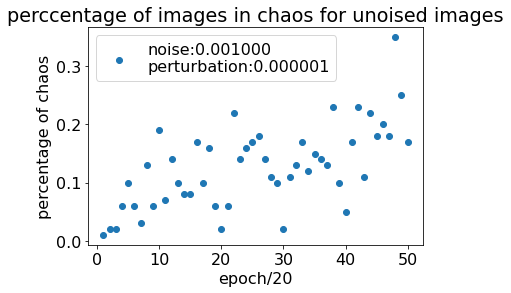

In [25]:
my_file = open("percentage of chaos unoised.txt", "r")
  
# reading the file
data = my_file.read()
  
# replacing end of line('/n') with ' ' and
# splitting the text it further when '.' is seen.
data_into_list = data.replace('\n', ' ').split(" ")
print(data_into_list[:-1])
data=[]
for i in range(len(data_into_list[:-1])):
    data.append(float(data_into_list[i]))
print(data)
x=np.arange(1,51)
labels="noise:{:F}\nperturbation:{:F}".format(10**-3,10**-6)
plt.scatter(x,y=data,label=labels)
#labels="noise:"+str(noise_strength)+", perturbation:"+str(perturbation_strength)
plt.ylabel("percentage of chaos")
plt.xlabel("epoch/20")
#plt.yscale("log")
plt.title("perccentage of images in chaos for unoised images")

#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.savefig("average jacobian.jpg")

plt.show()